In [76]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import requests
from itertools import combinations, permutations
from time import time
from numpy.random import random
from scipy.stats import spearmanr, chisquare
import pandas as pd
from fare.metrics import * #_count_inversions,_merge_parity,_merge_eq
import pickle
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = 10,5
from sklearn.isotonic import IsotonicRegression
from yang_metrics import *
import met
import statsmodels
import statsmodels.stats.weightstats

**load data from pickle files --- TOP 25 EXPERTS -- ALL DATA AT BOTTOM OF NOTEBOOK**

In [77]:
#top 25 experts' rankings of Wide recievers for 16 weeks of the season
# top25_dfs is a dictionary containing dataframes of rankings for one week.
# each column is a ranking of 55 players. The last column "Division" gives the group labels for each player

pkl_file = open('../top25_dfs.pickle', 'rb')
top25_dfs = pickle.load(pkl_file)
pkl_file.close()

In [78]:
# Create version for just for top 10 players each week
dfs10 = {}
for week in range(1,17):
    dd = top25_dfs[week].drop('Division', axis=1)
    top10 = dd.mean(axis=1).sort_values().rank()[:10].index.values
    dfs10[week] = top25_dfs[week].drop('Division', axis=1).loc[top10].rank(ascending=True)
    dfs10[week]['Division'] = top25_dfs[week].loc[top10]['Division']

In [151]:
#check likelihood that rankings meet monotonicity condition
def meets_condition(df):
    # compute whole value counts not proportion for chi2 test
    dfs=[]
    for c in df.columns.values:
        dfs.append(df[c].value_counts())
    counts = pd.concat(dfs, axis=1).fillna(value=0).sum(axis=1)

    # Fit IsotonicRegression
    x = list(range(1,len(counts)+1))
    y = counts.values
    ir = IsotonicRegression(increasing='auto')
    y_ = ir.fit_transform(x, y)
    
    y_prob = y/y.sum()
    y_hat_prob = y_/y_.sum()
    
    y_random = np.random.choice(len(y_prob), 300, p=y_prob)
    y_hat_random = np.random.choice(len(y_hat_prob), 300, p=y_hat_prob)

    
#     print('y_ mean')
#     print(y_.mean())
    e_region = 0.15*y_hat_random.mean()
    newp = statsmodels.stats.weightstats.ttost_ind(y_random, y_hat_random, -e_region, e_region)[0]
#     print('new p')
#     print(newp)
    pval = newp#chisquare(y, f_exp=y_)[1]
    print('pval', pval)
#     print(y)
#     print(y_)
#     print()
    #small pvalue means we reject he null hypothesis that the samples come from the same distribution
    return pval < 0.05

In [152]:
#check likelihood that rankings meet monotonicity condition
def meets_condition_multi(df):
    # compute whole value counts not proportion for chi2 test
    dfs=[]
    for c in df.columns.values:
        dfs.append(df[c].value_counts())
    counts = pd.concat(dfs, axis=1).fillna(value=0).sum(axis=1)

    # Fit IsotonicRegression
    x = list(range(1,len(counts)+1))
    y = counts.values
    ir = IsotonicRegression(increasing='auto')
    y_ = ir.fit_transform(x, y)
    
    
    y_ = (y_/10).astype(int)
    y = (y/10).astype(int)
    
    print(y_.astype(int))
    print(y)
    t1 = met.Multinom(y, y_)
    
    pval = t1.onesided_exact_test() 
    
    print(p_val)
    
    #pval = chisquare(y, f_exp=y_)[1]

    #small pvalue means we reject he null hypothesis that the samples come from the same distribution
    return pval > 0.5

**Single week: check monotonocity condition for entire ranking vs top10**

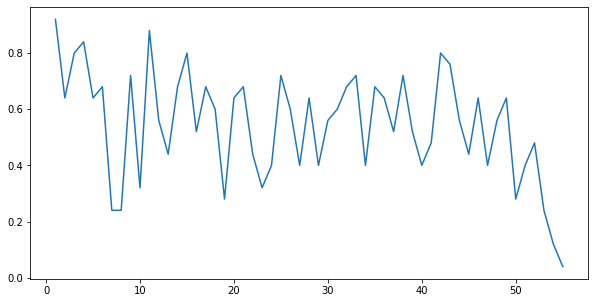

In [114]:
df = top25_dfs[1].drop('Division', axis=1).rank(ascending=True)
df = df[top25_dfs[1]['Division']==1.]
# r1 = df[df['Division']==0.]['Rank1'].value_counts()
# r2 = df[df['Division']==0.]['Rank2'].value_counts()
dfs=[]
for c in df.columns.values:
    dfs.append(df[c].value_counts())
counts = pd.concat(dfs, axis=1).fillna(value=0).sum(axis=1)/25
counts.plot()
plt.savefig("entire.png")

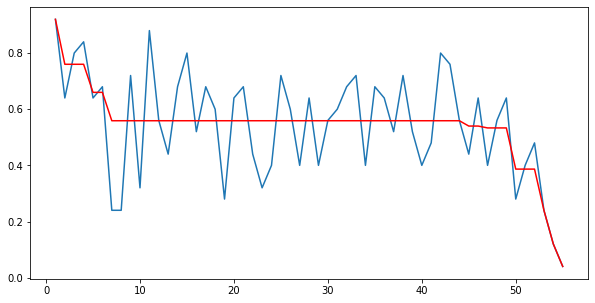

<Figure size 720x360 with 0 Axes>

In [115]:
# Fit IsotonicRegression
x = list(range(1,len(counts)+1))
y = counts.values
ir = IsotonicRegression(increasing='auto')
y_ = ir.fit_transform(x, y)
fig=counts.plot()
fig.plot(x,y_, c='red')
plt.show()
plt.savefig("entire_mono.png")

In [116]:
meets_condition(df)

pval 0.004906300992501562


True

In [117]:
dd = top25_dfs[4].drop('Division', axis=1)
top10 = dd.mean(axis=1).sort_values().rank()[:10].index.values
df10 = top25_dfs[4].drop('Division', axis=1).loc[top10].rank(ascending=True)
df10.head()

,Rank1,Rank2,Rank3,Rank4,Rank5,Rank6,Rank7,Rank8,Rank9,Rank10,...,Rank16,Rank17,Rank18,Rank19,Rank20,Rank21,Rank22,Rank23,Rank24,Rank
Julio Jones,1.0,3.0,1.0,1.0,1.0,2.0,3.0,1.0,1.0,1.0,...,1.0,1.0,6.0,3.0,1.0,1.0,3.0,1.0,5.0,1.0
Keenan Allen,2.0,2.0,2.0,2.0,2.0,4.0,2.0,2.0,2.0,2.0,...,2.0,3.0,3.0,2.0,3.0,2.0,2.0,2.0,3.0,2.0
DeAndre Hopkins,4.0,4.0,4.0,5.0,3.0,1.0,5.0,3.0,3.0,5.0,...,5.0,2.0,5.0,4.0,4.0,3.0,1.0,3.0,2.0,3.0
Davante Adams,3.0,1.0,3.0,3.0,5.0,5.0,1.0,6.0,6.0,3.0,...,9.0,5.0,1.0,1.0,2.0,10.0,5.0,5.0,1.0,5.0
Odell Beckham Jr.,6.0,5.0,5.0,8.0,4.0,8.0,6.0,4.0,7.0,6.0,...,6.0,4.0,7.0,5.0,5.0,5.0,4.0,4.0,8.0,4.0


<AxesSubplot:>

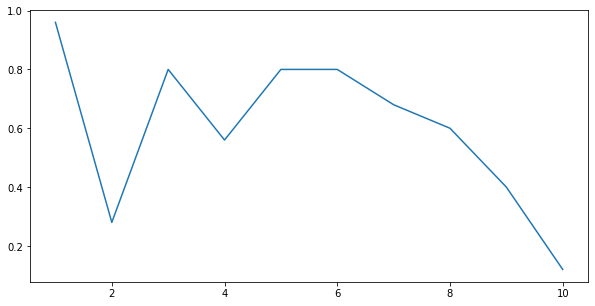

In [118]:
df10 = df10[top25_dfs[4].loc[top10]['Division']==1.]

dfs=[]
for c in df10.columns.values:
    dfs.append(df10[c].value_counts())
counts10 = pd.concat(dfs, axis=1).fillna(value=0).sum(axis=1)/25
counts10.plot()

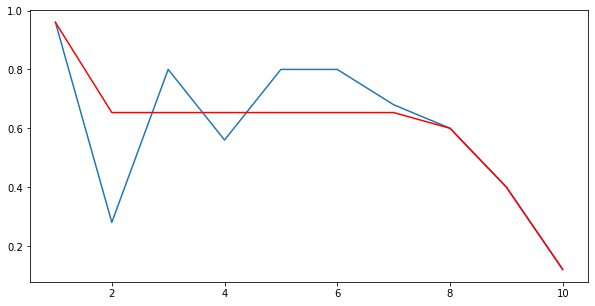

In [119]:
# Fit IsotonicRegression
x = list(range(1,len(counts10)+1))
y = counts10.values
ir = IsotonicRegression(increasing='auto')
y_ = ir.fit_transform(x, y)
fig=counts10.plot()
fig.plot(x,y_, c='red')
plt.show()

**Evaluate all fairness metrics**

**evaluate metrics week to week to verify meeting condition predicts behavior**

In [120]:
#rank_parity method from the FARE repo gives the normalized absolute difference of the rpar scores for each group
# If you want to compute the pairwise advantage for each group separately you can use this method

from fare.metrics import _count_inversions,_merge_parity,_merge_eq

def rank_parity(y,groups):
    r = np.transpose([y,groups])
    r = r[r[:,0].argsort()]
    g= np.array(r[:,1], dtype=int)
    e0 = _count_inversions(g, 0, len(g)-1, _merge_parity, 0)[1]
    e1 = _count_inversions(g, 0, len(g)-1, _merge_parity, 1)[1]

    return e0,e1

In [121]:
# $rKL$, $rRD$, $rND$, $expRR$, $expDCG$, and $rPar$ : key metrics
def getMetrics(window, ranking, sensi_idx):
    
    rank_len=len(ranking)
    r = len(sensi_idx)
    
    msn = []
    
    #get max vals for normalization
    max_rKL = getNormalizer(rank_len,r,KL_DIVERGENCE,window)  
    max_rND = getNormalizer(rank_len,r,ND_DIFFERENCE,window) 
    max_rRD = getNormalizer(rank_len,r,RD_DIFFERENCE,window) 
    normRR = getExpRRNormalizer(rank_len,r/rank_len)
    normDCG = getExpRRNormalizer(rank_len,r/rank_len)  

    #calculate normalized values
    fair_rND = calculateNDFairness(ranking, sensi_idx, window,ND_DIFFERENCE,max_rND)
    fair_rRD = calculateNDFairness(ranking, sensi_idx, window,RD_DIFFERENCE,max_rRD)
    fair_rKL = calculateNDFairness(ranking, sensi_idx, window,KL_DIVERGENCE,max_rKL)
            
    rr = calculaterExpRR(ranking, sensi_idx, rank_len, r)
    fair_expRR = (rr - normRR[0])/(normRR[1] - normRR[0])
    dcg = calculaterExpDCG(ranking, sensi_idx, rank_len, r)
    fair_expDCG = (dcg - normDCG[0])/(normDCG[1] - normDCG[0])
    
    groups = [0 if x in sensi_idx else 1 for x in np.arange(rank_len)]
    e0,e1 = rank_parity(np.arange(rank_len), groups)
    n_pairs = r*(rank_len-r)
    fair_Rpar = abs(e0 - e1)/n_pairs 
    
    msn.append([fair_rND, fair_rKL, fair_expRR, fair_expDCG, fair_Rpar, fair_rRD])

    cols = ['rND','rKL', 'expRR', 'expDCG', 'Rpar', 'rRD']
    return pd.DataFrame(msn, columns=cols)

In [122]:
meets={}
doesnt_meet={}
meets10={}
doesnt_meet10={}

for week in range(1,17):
    df = top25_dfs[week].drop('Division', axis=1).rank(ascending=True)
    df = df[top25_dfs[week]['Division']==1.]
    if meets_condition(df):
        meets[week]=df
    else:
        doesnt_meet[week]=df

for week in range(1,17):
    df = dfs10[week].drop('Division', axis=1).rank(ascending=True)
    df = df[dfs10[week]['Division']==1.]
    if meets_condition(df):
        meets10[week]=df
    else:
        doesnt_meet10[week]=df

pval 0.00021102206911128378
pval 3.6696611442189403e-05
pval 0.0026755227504636128
pval 0.0022112016958128864
pval 0.0023489762381194187
pval 0.054696436746771326
pval 0.010050462413889134
pval 0.0407991795110642
pval 0.07417366256668237
pval 0.0008450510646997389
pval 0.002214562797598573
pval 0.00044497893153960046
pval 0.026544752877244095
pval 0.00026804446883360453
pval 0.07477505800547676
pval 0.0001531444756629677
pval 0.008014263345677546
pval 0.0010357665675116041
pval 7.256157560616105e-05
pval 0.017712255727853784
pval 0.6182082285293811
pval 0.01125536690318382
pval 0.011879795611764483
pval 0.00029784686665436394
pval 0.02279966564842217
pval 0.020696862058701138
pval 0.2660412795364997
pval 0.00043568993406526243
pval 0.10630368514987211
pval 0.003278229364387453
pval 0.006924237740461463
pval 0.19580089172355836


In [123]:
def plot_metrics(dfs, weeks, window):
    #compute the expected (average) metric values each week for full rankings
    cols = ['rND','rKL', 'expRR', 'expDCG', 'Rpar', 'rRD']
    metrics = pd.DataFrame()

    for week in weeks:
        df = dfs[week].drop('Division', axis=1).rank(ascending=True)
        df['Division'] = dfs[week]['Division']
        ms = pd.DataFrame(columns=cols)
        for c in df.drop('Division',axis=1).columns.values:
            ranking = df[[c,'Division']].sort_values(c)
            sensi_idx = [i for i,x in enumerate(ranking['Division'].values) if x==0]
            rank = ranking[c].astype(int)
            ms= pd.concat([ms,getMetrics(window, rank, sensi_idx)])
        metrics[week]=ms.mean()
    metrics.transpose().plot()
    plt.show()
    plt.clf()
    corr = metrics.transpose().corr().values
    mask = np.triu(np.ones_like(corr, dtype=np.bool))
    ax = sns.heatmap(corr, vmin=-1, mask=mask, vmax=1, annot=True, center=0,cmap=sns.diverging_palette(20, 220, n=200),
                                 square=True, cbar=False)


    ax.set_xticklabels(metrics.index.values,rotation=45,horizontalalignment='right')
    ax.set_yticklabels(metrics.index.values,rotation=45,horizontalalignment='right')

entire, meets condition


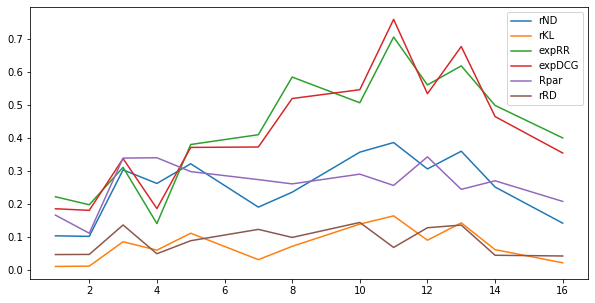

entire, doesn't meet condition


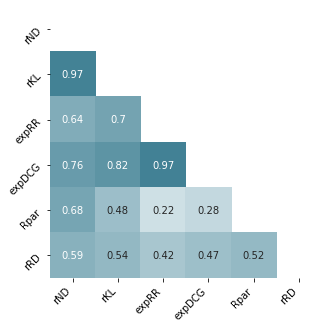

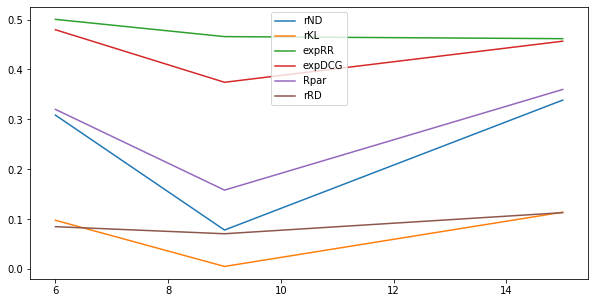

top 10, meets condition


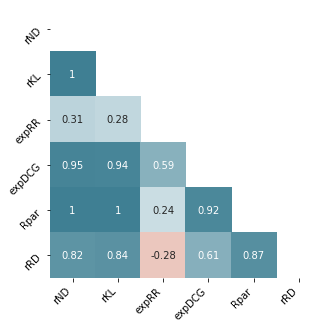

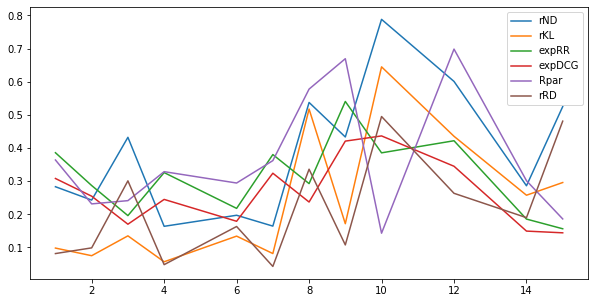

top 10, doesn't meet condition


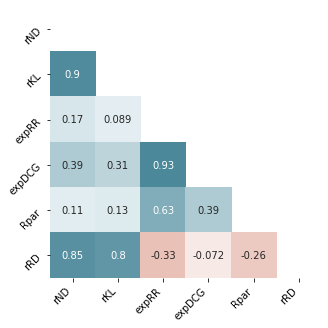

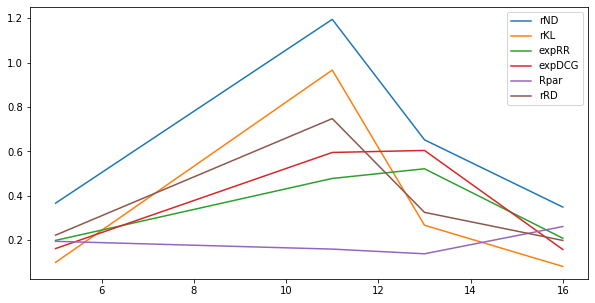

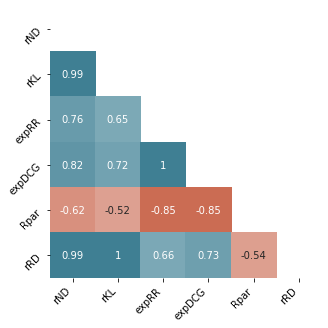

In [124]:
print("entire, meets condition")
plot_metrics(top25_dfs, meets.keys(), 10)
print("entire, doesn't meet condition")
plot_metrics(top25_dfs, doesnt_meet.keys(), 10)
print("top 10, meets condition")
plot_metrics(dfs10, meets10.keys(), 5)
print("top 10, doesn't meet condition")
plot_metrics(dfs10, doesnt_meet10.keys(), 5)

** LOAD DATA -- ALL EXPERTS**

In [130]:
# all experts' rankings of Wide recievers for 16 weeks of the season (experts who ranked players every week)
# dfs is a dictionary containing dataframes of rankings for one week.
#there are 92 experts 
# each column is a ranking of roughly 50 players. The last column "Division" gives the group labels for each player

pkl_file = open('dfs.pickle', 'rb')
dfs = pickle.load(pkl_file)
pkl_file.close()

In [131]:
[*dfs.keys()]

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

<AxesSubplot:>

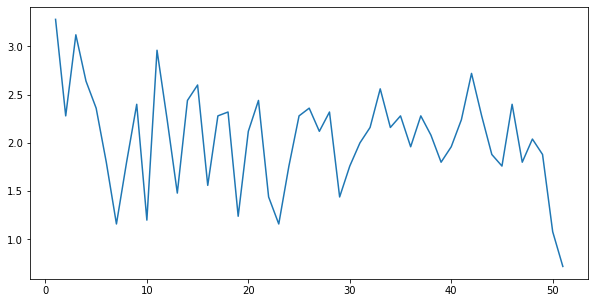

In [132]:

# Check monotonicity for a single week
week = 1
df = dfs[week].drop('Division', axis=1).rank(ascending=True)
df = df[dfs[week]['Division']==1.]
# r1 = df[df['Division']==0.]['Rank1'].value_counts()
# r2 = df[df['Division']==0.]['Rank2'].value_counts()
dfs=[]
for c in df.columns.values:
    dfs.append(df[c].value_counts())
counts = pd.concat(dfs, axis=1).fillna(value=0).sum(axis=1)/25
counts.plot()
#plt.savefig("entire.png")

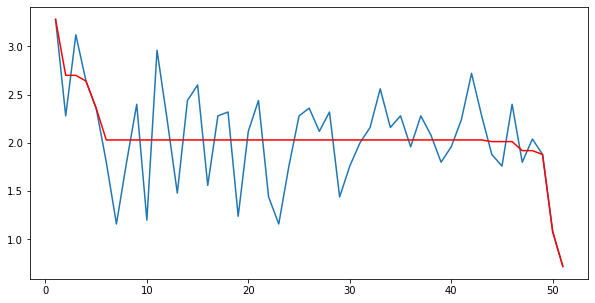

In [133]:
# Fit IsotonicRegression
x = list(range(1,len(counts)+1))
y = counts.values
ir = IsotonicRegression(increasing='auto')
y_ = ir.fit_transform(x, y)
fig=counts.plot()
fig.plot(x,y_, c='red')
plt.show()
#plt.savefig("entire_mono.png")

In [134]:
meets_condition(df)

pval 0.0021738314926315313


True

In [135]:
num_reviewers = 90

pkl_file = open('dfs.pickle', 'rb')#open('../top25_dfs.pickle', 'rb')
dfs = pickle.load(pkl_file)
pkl_file.close()

meets10 = {}
doesnt_meet10 = {}

num_meets = 0

for week in [*dfs.keys()]:

    pkl_file = open('dfs.pickle', 'rb')#open('../top25_dfs.pickle', 'rb')
    dfs = pickle.load(pkl_file)
    pkl_file.close()
    
    dfs10 = {}
    for d_week in [*dfs.keys()]:
        dd = dfs[d_week].drop('Division', axis=1)
        top10 = dd.mean(axis=1).sort_values().rank()[:10].index.values
        dfs10[d_week] = dfs[d_week].drop('Division', axis=1).loc[top10].rank(ascending=True)
        dfs10[d_week]['Division'] = dfs[d_week].loc[top10]['Division']
    dfs = dfs10

    # Check monotonicity for a single week
    df = dfs[week].drop('Division', axis=1).rank(ascending=True)
    df = df[dfs[week]['Division']==1.]
    
    if meets_condition(df):
        print(week)
        meets10[week] = week
        num_meets += 1
    else:
        doesnt_meet10[week] = week


pval 0.0032273602011161358
1
pval 0.01591748012050736
2
pval 0.0002579593488363502
3
pval 0.023399750042744888
4
pval 0.43470298117408956
pval 0.0015870085377474503
6
pval 0.18189503068351043
pval 0.0027629604464534316
8
pval 0.02696255610527243
9
pval 0.15164550696467383
pval 0.0047155819092796715
11
pval 0.02137221994097348
12
pval 0.00029902006300431514
13
pval 0.0005724126722836376
14
pval 0.05231651451947153
pval 0.008474060146234133
16


In [136]:
num_meets/len([*dfs.keys()])

0.75

In [137]:
num_meets

12

In [138]:
len([*dfs.keys()])

16

In [139]:
meets10

{1: 1,
 2: 2,
 3: 3,
 4: 4,
 6: 6,
 8: 8,
 9: 9,
 11: 11,
 12: 12,
 13: 13,
 14: 14,
 16: 16}

In [140]:
#top 10, 90 rankers: 9/16
#All players, 90 ranekrs: 3/16

#Top 10, 25 rankers: 14/16
#All players, 25 rankers: 8/16



In [141]:
for week in [*meets10.keys()]:
    print(week)

1
2
3
4
6
8
9
11
12
13
14
16


ValueError: num must be 1 <= num <= 12, not 0

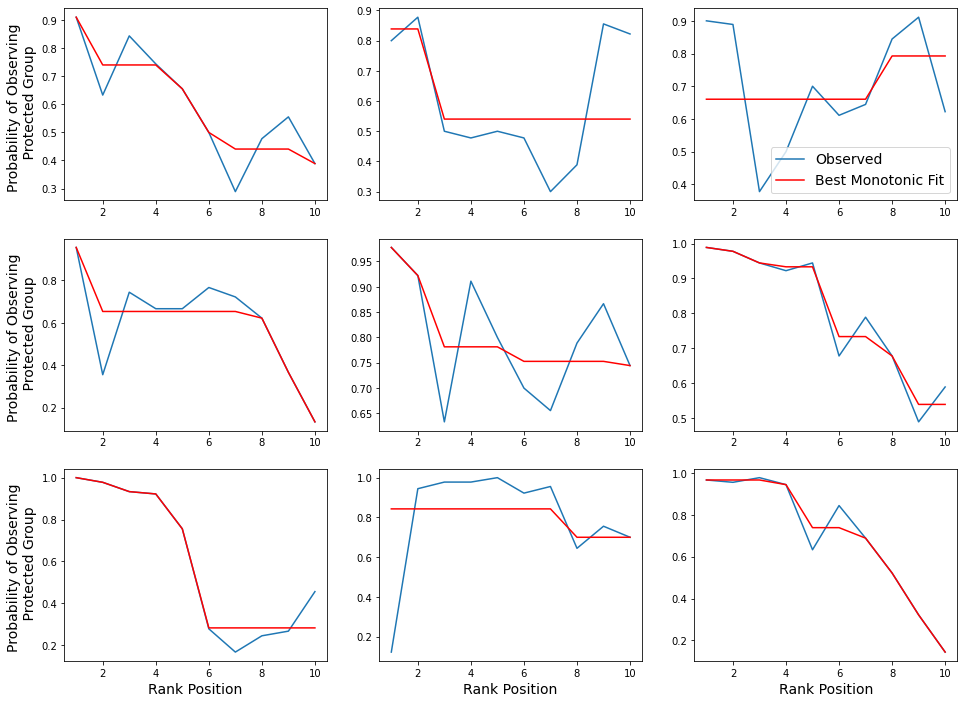

In [142]:
plt.figure(figsize=(16,12)) ## setting over-all figure size (optional)
plt.subplot(3, 3, 1) 

for indx, week in enumerate([*meets10.keys()]):
    
    pkl_file = open('dfs.pickle', 'rb')#open('dfs.pickle', 'rb')
    dfs = pickle.load(pkl_file)
    pkl_file.close()

    dfs10 = {}
    for d_week in [*dfs.keys()]:
        dd = dfs[d_week].drop('Division', axis=1)
        top10 = dd.mean(axis=1).sort_values().rank()[:10].index.values
        dfs10[d_week] = dfs[d_week].drop('Division', axis=1).loc[top10].rank(ascending=True)
        dfs10[d_week]['Division'] = dfs[d_week].loc[top10]['Division']
    dfs = dfs10

    # Check monotonicity for a single week
    df = dfs[week].drop('Division', axis=1).rank(ascending=True)
    df = df[dfs[week]['Division']==1.]
    # r1 = df[df['Division']==0.]['Rank1'].value_counts()
    # r2 = df[df['Division']==0.]['Rank2'].value_counts()
    dfs=[]
    for c in df.columns.values:
        dfs.append(df[c].value_counts())

    counts = pd.concat(dfs, axis=1).fillna(value=0).sum(axis=1)/90
    x = list(range(1,len(counts)+1))
    y = counts.values
    ir = IsotonicRegression(increasing='auto')
    y_ = ir.fit_transform(x, y)
    
    plt.subplot(330 + indx+1)
    
    fig=counts.plot(label='Observed')

    fig.plot(x,y_, c='red', label='Best Monotonic Fit')
    if (indx+1) in [7,8,9]:
        plt.xlabel('Rank Position', size=14)
    
    if (indx+1) in [1,4,7]:
        plt.ylabel('Probability of Observing \n Protected Group', size=14)
        
    if (indx+1) in [3]:
        plt.legend(fontsize=14)


In [153]:
num_reviewers = 90

positions = ['WR','QB','RB','TE']

pos_player_meets = {}

for f_pos in positions:
    pos_player_meets[f_pos] = {}
    print(f_pos)
    print()
    for use_top_10 in [True, False]:
        
        
        if use_top_10:
            print('Top 10:') 
        else:
            print('All Users:')


        pkl_file = open('all_dfs.pickle', 'rb')
        all_dfs = pickle.load(pkl_file)
        pkl_file.close()

        dfs = all_dfs[f_pos]

        meets10 = {}
        doesnt_meet10 = {}
        
        all_weeks = [*dfs.keys()]

        num_meets = 0


        for week in [*dfs.keys()]:

            pkl_file = open('all_dfs.pickle', 'rb')
            all_dfs = pickle.load(pkl_file)
            pkl_file.close()

            dfs = all_dfs[f_pos]
            
            if use_top_10:
                
                dfs10 = {}
                for d_week in [*dfs.keys()]:
                    dd = dfs[d_week].drop('Division', axis=1)
                    top10 = dd.mean(axis=1).sort_values().rank()[:10].index.values
                    dfs10[d_week] = dfs[d_week].drop('Division', axis=1).loc[top10].rank(ascending=True)
                    dfs10[d_week]['Division'] = dfs[d_week].loc[top10]['Division']
                dfs = dfs10
            

            # Check monotonicity for a single week
            df = dfs[week].drop('Division', axis=1).rank(ascending=True)
            df = df[dfs[week]['Division']==1.]

            if meets_condition(df):
                #print(week)
    
                meets10[week] = week
                num_meets += 1
            else:
                doesnt_meet10[week] = week
        print(num_meets)
        print()
        
        if use_top_10:
            pos_player_meets[f_pos]['top_10'] = meets10
        else:
            pos_player_meets[f_pos]['all'] = meets10
            
        

WR

Top 10:
pval 0.04967373669605008
pval 0.30935093222979604
pval 0.04100322017219051
pval 0.005569907240819642
pval 0.213206140563017
pval 0.035471108040953776
pval 0.00948870997775013
pval 0.009602891260081606
pval 0.02238548042127501
pval 0.05453454399004224
pval 0.3019363787871069
pval 0.029447415502340816
pval 0.1656060926271521
pval 0.013622737403291483
pval 0.0041628680708622415
pval 0.13569631935077225
10

All Users:
pval 0.00165090104239189
pval 0.010014220194676038
pval 0.0652233785080471
pval 0.006604951183089417
pval 0.0409709789475204
pval 0.006835679479479433
pval 0.0748418150913348
pval 0.10778648762188553
pval 0.2704955357167479
pval 0.05083545819830316
pval 0.041114702113299206
pval 0.25139522474791176
pval 0.16048672389089488
pval 0.036828631779345075
pval 0.4555217958881096
pval 0.0070822900066884265
8

QB

Top 10:
pval 0.015758418861933087
pval 0.0007937461270928128
pval 0.00014338860601379645
pval 2.679936985842864e-05
pval 9.525731217163499e-06
pval 1.79124809822

In [58]:
week

15

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
QB
True


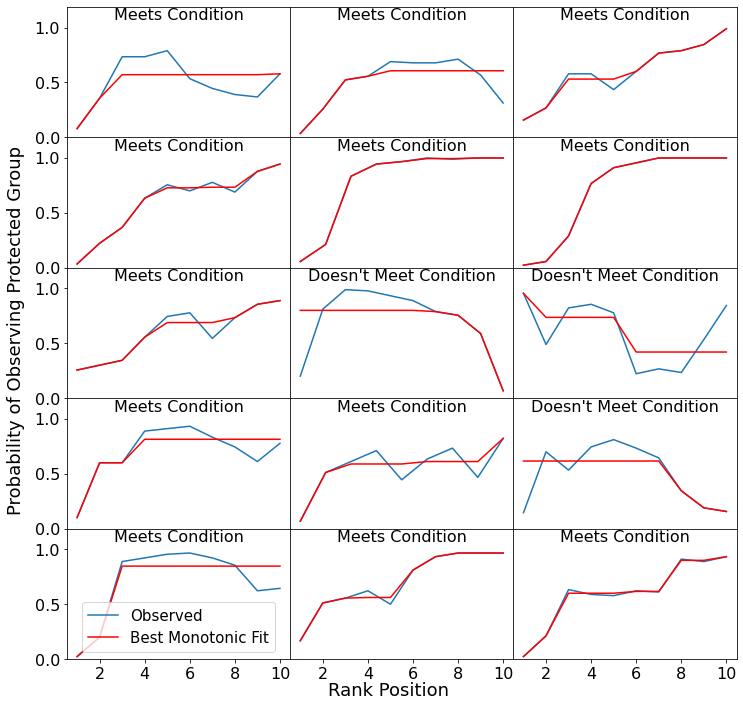

In [154]:


for f_pos in ['QB']:#positions:
    for use_top_10 in [True, False]:
        
        plt.figure(figsize=(12,12)) ## setting over-all figure size (optional)
        plt.subplot(5, 3, 1)
        
        
        for indx, week in enumerate(all_weeks[:-1]):

            pkl_file = open('all_dfs.pickle', 'rb')
            all_dfs = pickle.load(pkl_file)
            pkl_file.close()

            dfs = all_dfs[f_pos]

            if use_top_10:
                dfs10 = {}
                for d_week in [*dfs.keys()]:
                    dd = dfs[d_week].drop('Division', axis=1)
                    top10 = dd.mean(axis=1).sort_values().rank()[:10].index.values
                    dfs10[d_week] = dfs[d_week].drop('Division', axis=1).loc[top10].rank(ascending=True)
                    dfs10[d_week]['Division'] = dfs[d_week].loc[top10]['Division']
                dfs = dfs10



            # Check monotonicity for a single week
            df = dfs[week].drop('Division', axis=1).rank(ascending=True)
            df = df[dfs[week]['Division']==1.]
            # r1 = df[df['Division']==0.]['Rank1'].value_counts()
            # r2 = df[df['Division']==0.]['Rank2'].value_counts()
            dfs=[]
            for c in df.columns.values:
                dfs.append(df[c].value_counts())

            counts = pd.concat(dfs, axis=1).fillna(value=0).sum(axis=1)/90
            x = list(range(1,len(counts)+1))
            y = counts.values
            ir = IsotonicRegression(increasing='auto')
            y_ = ir.fit_transform(x, y)
            
            print(indx+1)
            ax2 = plt.subplot(5,3,0 + indx+1)
            ax2.set_ylim([0, 1.19])
            ax2.tick_params(axis='both', which='major', labelsize=16)
            
            fig=counts.plot(label='Observed')
            
        
            if week in [5,11]:
                fig.plot([xx+1 for xx in x],y_, c='red', label='Best Monotonic Fit')
            else:
                fig.plot(x,y_, c='red', label='Best Monotonic Fit')
            if (indx+1) in [13,14,15,16]:
                #plt.xlabel('Rank Position', size=12)
                bloop = 0
                plt.xticks([2,4,6,8,10])
            else:
                plt.xticks([])

            if (indx+1) in [1,4,7,10, 13]:
                boop=0
                #plt.ylabel('Probability of Observing \n Protected Group', size=12)
            else:
                plt.yticks([])

            if (indx+1) in [13]:
                plt.legend(loc='lower center', fontsize=15)

            if use_top_10:
                if week in [*pos_player_meets[f_pos]['top_10'].keys()]:
                    figure_title = 'Meets Condition'
                else:
                    figure_title = 'Doesn\'t Meet Condition'
            else:
                if week in [*pos_player_meets[f_pos]['all'].keys()]:
                    figure_title = 'Meets Condition'
                else:
                    figure_title = 'Doesn\'t Meet Condition'

            plt.text(0.5, .9, figure_title,
                     horizontalalignment='center',
                     fontsize=16,
                     transform = ax2.transAxes)
            
        
        print(f_pos)
        print(use_top_10)
        
        fig.text(-5, -0.29, 'Rank Position', ha='center', va='center', size=18)
        fig.text(-21.5, 3.0, 'Probability of Observing Protected Group', ha='center', va='center', rotation='vertical', size=18)
        
        plt.subplots_adjust(hspace=.0)
        plt.subplots_adjust(wspace=.0)
        plt.savefig("qb_10.pdf", bbox_inches='tight')
        plt.show()
        break
    break


In [63]:
[xx-1 for xx in x]

[0, 1, 2, 3, 4, 5, 6, 7, 8]

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
WR
True


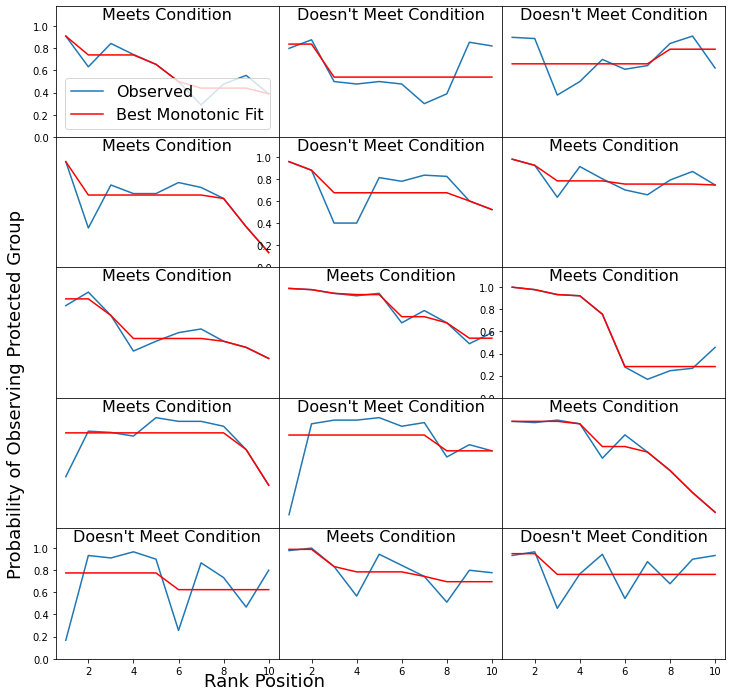

In [40]:


for f_pos in positions:
    for use_top_10 in [True, False]:
        
        plt.figure(figsize=(16,12)) ## setting over-all figure size (optional)
        plt.subplot(4, 4, 1)
        
        
        for indx, week in enumerate(all_weeks):

            pkl_file = open('all_dfs.pickle', 'rb')
            all_dfs = pickle.load(pkl_file)
            pkl_file.close()

            dfs = all_dfs[f_pos]

            if use_top_10:
                dfs10 = {}
                for d_week in [*dfs.keys()]:
                    dd = dfs[d_week].drop('Division', axis=1)
                    top10 = dd.mean(axis=1).sort_values().rank()[:10].index.values
                    dfs10[d_week] = dfs[d_week].drop('Division', axis=1).loc[top10].rank(ascending=True)
                    dfs10[d_week]['Division'] = dfs[d_week].loc[top10]['Division']
                dfs = dfs10



            # Check monotonicity for a single week
            df = dfs[week].drop('Division', axis=1).rank(ascending=True)
            df = df[dfs[week]['Division']==1.]
            # r1 = df[df['Division']==0.]['Rank1'].value_counts()
            # r2 = df[df['Division']==0.]['Rank2'].value_counts()
            dfs=[]
            for c in df.columns.values:
                dfs.append(df[c].value_counts())

            counts = pd.concat(dfs, axis=1).fillna(value=0).sum(axis=1)/90
            x = list(range(1,len(counts)+1))
            y = counts.values
            ir = IsotonicRegression(increasing='auto')
            y_ = ir.fit_transform(x, y)
            
            print(indx+1)
            ax2 = plt.subplot(4,4,0 + indx+1)
            ax2.set_ylim([0, 1.18])
            
            fig=counts.plot(label='Observed')

            fig.plot(x,y_, c='red', label='Best Monotonic Fit')
            if (indx+1) in [13,14,15,16]:
                #plt.xlabel('Rank Position', size=12)
                bloop = 0
            else:
                plt.xticks([])

            if (indx+1) in [1,5,9, 13]:
                boop=0
                #plt.ylabel('Probability of Observing \n Protected Group', size=12)
            else:
                plt.yticks([])

            if (indx+1) in [1]:
                plt.legend(loc='lower center', fontsize=16)

            if use_top_10:
                if week in [*pos_player_meets[f_pos]['top_10'].keys()]:
                    figure_title = 'Meets Condition'
                else:
                    figure_title = 'Doesn\'t Meet Condition'
            else:
                if week in [*pos_player_meets[f_pos]['all'].keys()]:
                    figure_title = 'Meets Condition'
                else:
                    figure_title = 'Doesn\'t Meet Condition'

            plt.text(0.5, .9, figure_title,
                     horizontalalignment='center',
                     fontsize=16,
                     transform = ax2.transAxes)
            
        
        print(f_pos)
        print(use_top_10)
        
        fig.text(-10, -0.2, 'Rank Position', ha='center', va='center', size=18)
        fig.text(-31.0, 2.4, 'Probability of Observing Protected Group', ha='center', va='center', rotation='vertical', size=18)
        
        plt.subplots_adjust(hspace=.0)
        plt.subplots_adjust(wspace=.0)
        plt.savefig("qb_10.pdf", bbox_inches='tight')
        plt.show()
        break
    break


In [221]:
[*dfs.keys()]

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

In [226]:
pkl_file = open('all_dfs.pickle', 'rb')
all_dfs = pickle.load(pkl_file)
pkl_file.close()

dfs = all_dfs[f_pos]

meets10 = {}
doesnt_meet10 = {}

num_meets = 0

all_weeks = [*dfs.keys()]

In [198]:
dfs

[9.0     1
 10.0    1
 7.0     1
 4.0     1
 5.0     1
 3.0     1
 2.0     1
 1.0     1
 Name: Rank1, dtype: int64, 9.0     1
 10.0    1
 7.0     1
 6.0     1
 2.0     1
 5.0     1
 3.0     1
 1.0     1
 Name: Rank2, dtype: int64, 10.0    1
 7.0     1
 8.0     1
 6.0     1
 5.0     1
 2.0     1
 3.0     1
 1.0     1
 Name: Rank3, dtype: int64, 10.0    1
 9.0     1
 6.0     1
 5.0     1
 4.0     1
 2.0     1
 3.0     1
 1.0     1
 Name: Rank4, dtype: int64, 9.0     1
 10.0    1
 7.0     1
 6.0     1
 2.0     1
 5.0     1
 3.0     1
 1.0     1
 Name: Rank5, dtype: int64, 10.0    1
 9.0     1
 6.0     1
 5.0     1
 4.0     1
 1.0     1
 3.0     1
 2.0     1
 Name: Rank6, dtype: int64, 6.0     1
 10.0    1
 9.0     1
 5.0     1
 8.0     1
 1.0     1
 4.0     1
 2.0     1
 Name: Rank7, dtype: int64, 10.0    1
 9.0     1
 7.0     1
 6.0     1
 5.0     1
 2.0     1
 3.0     1
 1.0     1
 Name: Rank8, dtype: int64, 9.0     1
 10.0    1
 7.0     1
 3.0     1
 6.0     1
 5.0     1
 2.0     1
 1.

In [196]:
counts

1.0     3.52
2.0     3.60
3.0     3.00
4.0     2.04
5.0     3.40
6.0     3.04
7.0     2.68
8.0     1.84
9.0     2.88
10.0    2.80
dtype: float64

NameError: name 'x1' is not defined

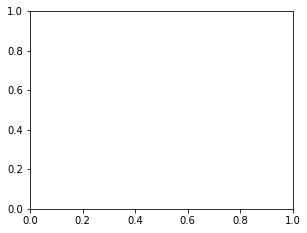

In [180]:
plt.figure(figsize=(16,8)) ## setting over-all figure size (optional)
plt.subplot(2, 3, 1) 

##  this creates 6 subplots (2 rows and 3 columns)
## 1 at the end means we are in the first subplot.. then...

plt.plot(x1,y1) ## for well-selected x1 and y1
plt.subplot(232) ## the same as subplot(2, 3, 2) - you can use this when values have
                 ## one digit only; now we are in the 2nd subplot
plt.plot(x2, y2)  ## this will be plotted in the second subplot

## etc. ...

plt.subplot(236)
plt.plot(x6,y6)

top 10, meets condition


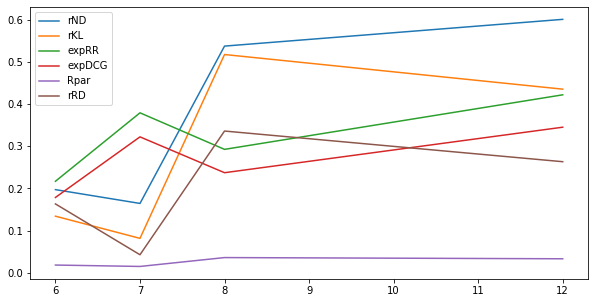

top 10, doesn't meet condition


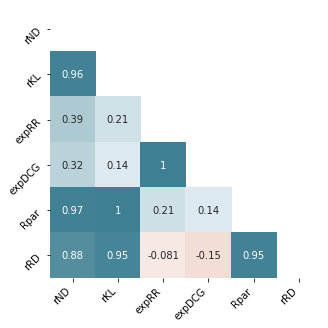

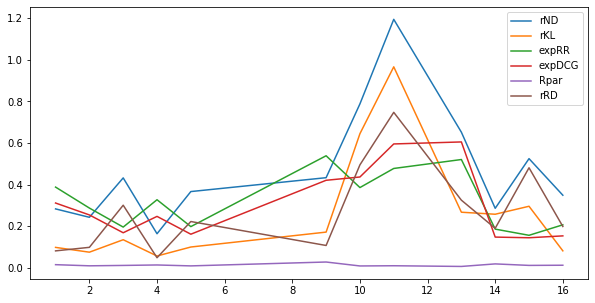

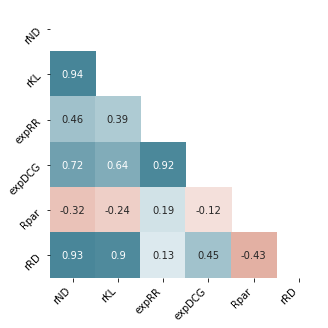

In [109]:
print("top 10, meets condition")
plot_metrics(dfs, meets10.keys(), 5)
print("top 10, doesn't meet condition")
plot_metrics(dfs, doesnt_meet10.keys(), 5)

In [49]:
[*dfs.keys()]

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]

In [50]:
dfs10 = {}
for week in range(1,17):
    dd = top25_dfs[week].drop('Division', axis=1)
    top10 = dd.mean(axis=1).sort_values().rank()[:10].index.values
    dfs10[week] = top25_dfs[week].drop('Division', axis=1).loc[top10].rank(ascending=True)
    dfs10[week]['Division'] = top25_dfs[week].loc[top10]['Division']